# Motivation

The notebook studies the volatility and returns of the S&P 500 index

Assumptions:
- Using historical market cap data from macrotrends
- Calculate returns based on historical close prices

| Use Case                           | Use Log Return Volatility    | Use Arithmetic Volatility |
| ---------------------------------- | ---------------------------- | ------------------------- |
| Theoretical models (e.g., GBM)     | ✅                            | ❌                         |
| Sharpe ratio, risk-adjusted return | ❌                            | ✅                         |
| Empirical finance, EDA             | ✅                            | ✅                         |
| Long horizon compounding           | ✅                            | ❌                         |
| Portfolio optimization             | Mixed (depends on framework) | ✅                         |

- Arithmetic returns is more intuitive and is used in Sharpe ratio calculations
- Log-returns are more convenient for theoretical models (e.g., Geometric Brownian Motion for compounding drift)

## Equations:
- Arithmetic Return (Simple or Percentage Return)
   - $r_t^{\text{arith}} = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1$

- Log Return (Continuously Compounded Return)
   - $r_t^{\text{log}} = \ln\left( \frac{P_t}{P_{t-1}} \right)$

- Relationship Between Log and Arithmetic Returns
  - $r_t^{\text{arith}} = e^{r_t^{\text{log}}} - 1$
  - $r_t^{\text{log}} = \ln(1 + r_t^{\text{arith}})$

- Taylor Expansion of Log Return (Around 0)
  - $ \ln(1 + r) = r - \frac{r^2}{2} + \frac{r^3}{3} - \frac{r^4}{4} + \cdots $
  - $\Rightarrow r_t^{\text{log}} \approx r_t^{\text{arith}} - \frac{1}{2} \left( r_t^{\text{arith}} \right)^2$
  - Note: if small changes then log return is close to arithmetic return

- Cumulative Return (Arithmetic)
  - $R_{0 \to T}^{\text{arith}} = \prod_{t=1}^T (1 + r_t^{\text{arith}}) - 1$

- Cumulative Return (Log)
  - $R_{0 \to T}^{\text{log}} = \sum_{t=1}^T r_t^{\text{log}} = \ln\left( \frac{P_T}{P_0} \right)$

- Annualization of Mean and Volatility
  - Multiplying mean by $N$ and volatility by $\sqrt{N}$ is **exact property of expectations under iid constant mean processes**
  - Assuming $N$ trading periods per year (e.g., 252 for daily returns):
  - Annualized Mean Return (Log):
    - $\mu_{\text{annual}}^{\text{log}} = N \cdot \bar{r}_{\text{log}}$
  - Annualized Mean Return (Arithmetic):
    - $\mu_{\text{annual}}^{\text{arith}} = N \cdot \bar{r}_{\text{arith}}$
  - Annualized Volatility (Both Types):
    - $\sigma_{\text{annual}} = \sqrt{N} \cdot \sigma_{\text{daily}}$

| Model                              | Purpose / Description                                                                                                                                                                                                                   | When to Use                                                                                                                                                                                    | Pros                                                                                                                                                                                  | Cons                                                                                                                                                                                     |
|------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Discounted Cash Flow (DCF)**     | Projects a company’s future free cash flows (FCF) to equity or to the firm and discounts them to present value using a chosen discount rate (typically WACC or cost of equity).                                                          | When you have reliable forecasts for revenue growth, margins, capex, and working capital; especially for established companies with reasonably predictable cash flows.                         | • Directly ties valuation to underlying cash-flow drivers<br>• Flexible: can model changing revenue, margins, capex, working capital, etc.<br>• Widely accepted as an “intrinsic” approach | • Highly sensitive to assumptions (growth rates, margins, discount rate)<br>• Terminal value often dominates—small tweaks in terminal inputs swing valuation<br>• Data-intensive        |
| **Dividend Discount Model (DDM)** / **Gordon Growth** | Values a stock as the present value of expected future dividends. <br>• Constant-growth form: $P_0 = \dfrac{D_1}{r - g}$ assumes dividends grow at a fixed rate $g$ forever.                                                                      | When the firm has a stable dividend policy and predictable payout ratio (e.g., utility companies, large blue-chips).                                                                            | • Very simple in constant-growth case (single formula)<br>• Directly captures yield + growth trade-off<br>• Ideal for mature, stable dividend payers                                   | • Only works for firms with predictable dividends (not for non-dividend payers)<br>• Assumes perpetual, constant growth ($g < r$)—hard to justify for high-growth or cyclical stocks |
| **Relative Valuation (Multiples)** | Values a stock by comparing its valuation multiples (P/E, EV/EBITDA, P/B, etc.) to a set of comparable peers. <br>Example: If Company A trades at 15× EV/EBITDA and Company B (similar profile) trades at 10×, B may be “cheap.”         | When you need a quick “sanity check” or peer comparison; suitable for sectors with homogeneous business models (e.g., retail, manufacturing) and readily available multiples.                | • Quick to implement—only needs market prices and basic financial metrics<br>• Reflects current market sentiment (peer pricing)<br>• Common sanity check alongside DCF/DDM               | • Requires a truly comparable peer group—difficult if no close peers exist<br>• Ignores company-specific fundamentals unless adjusted<br>• Market multiples can be temporarily distorted   |
| **Residual Income (RI) / EVA**     | Values equity as $P_0 = B_0 + \sum_{t=1}^{\infty} \dfrac{(ROE_t - r_e)\,B_{t-1}}{(1 + r_e)^t}$, where $B_t$ is book value at time $t$ and $r_e$ is cost of equity. Focuses on “excess” accounting profits above required return. | When dividends or FCF are erratic but accounting profits (ROE) are steady; useful for banks or insurance companies where book value and ROE are more stable metrics than cash flows.         | • Captures value created above cost of equity—suitable when FCF or dividends are erratic<br>• Connects accounting (book) to market value                                                 | • Requires reliable forecasts of future ROE and book value—often uncertain<br>• Sensitive to the choice of cost of equity $r_e$<br>• Less intuitive if reinvestment returns vary         |


In [287]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import pandas as pd
import yfinance as yf
from rich import box
from rich.console import Console
from rich.markdown import Markdown
from rich.panel import Panel
from rich.table import Table
from scipy import stats
from scipy.stats import norm, truncnorm, uniform

from fundamentals.utility.dcf import StandardDCFModel
from fundamentals.utility.general import update_plot_style

console = Console()

update_plot_style()

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.3f}'.format)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [215]:
sp500 = pd.read_parquet("../../macro_data/SP500_2025-03-31.parquet")

In [288]:
macrotrends = {}
# for ticker in ["AAPL"]:
for ticker in sp500.ticker.values:
    macrotrends[ticker] = pd.read_parquet(f"../../macro_data/parquet/{ticker}_2025-03-31.parquet")
    if len(macrotrends[ticker]) == 0:
        print(f"Warning: {ticker} has no macrotrends data")

In [217]:
start_date = next(iter(macrotrends.values())).index[-5]
end_date   = next(iter(macrotrends.values())).index[-1]

In [218]:
assert (end_date - start_date).days == 365 # ensure 1 year

In [219]:
tickers = " ".join(sp500.ticker.values)

# Use open price for the price
data = yf.download(tickers, start=start_date, end=end_date, interval='1d', group_by='ticker', auto_adjust=True)
open_data = data.xs('Open', axis=1, level='Price')

[*********************100%***********************]  503 of 503 completed


In [220]:
market_caps = {'ticker': [], 'marketCap': []}
for ticker, df in macrotrends.items():
    market_caps['ticker'].append(ticker)
    length_df = len(df['Market-Cap'])
    market_cap = df['Market-Cap'].iloc[max(-1, length_df-5)]
    market_caps['marketCap'].append(market_cap)
market_caps = pd.DataFrame(market_caps)

market_caps.index = market_caps.ticker
market_caps.drop(columns=['ticker'], inplace=True)
market_caps = market_caps.reindex(open_data.columns)

In [221]:
# 1. Compute daily log and arithmetic returns
logret = np.log(open_data / open_data.shift(1)).dropna()
arithret = open_data.pct_change().dropna()
trading_days = 252

# 2. Annualized volatility and mean
ann_vol_log = logret.std(axis=0) * np.sqrt(trading_days)
ann_vol_arith = arithret.std(axis=0) * np.sqrt(trading_days)
ann_mean_log = logret.mean(axis=0) * trading_days
ann_mean_arith = arithret.mean(axis=0) * trading_days
ann_ret_from_log = np.exp(ann_mean_log) - 1

# 3. Annualized volatility (cross-section)
#    vol_i = std(logret_i) * sqrt(trading_days)
ann_vol = logret.std(axis=0) * np.sqrt(trading_days)

# 4. Index weights (as of start date)
weights = market_caps['marketCap'].values / market_caps['marketCap'].sum()

# 5. Total returns over the year per ticker
tot_ret = (open_data.iloc[-1] / open_data.iloc[0] - 1)

assert np.isclose(sum(weights), 1)
assert sum(market_caps.index == tot_ret.index) == len(market_caps), f"market_caps.index: {market_caps.index} != tot_ret.index: {tot_ret.index}"

# 6. Contribution to index return
contrib = weights * tot_ret
contrib_sorted = contrib.sort_values(ascending=False)
contrib_sorted = contrib_sorted.reset_index()
contrib_sorted.columns = ['ticker', 'contribution']

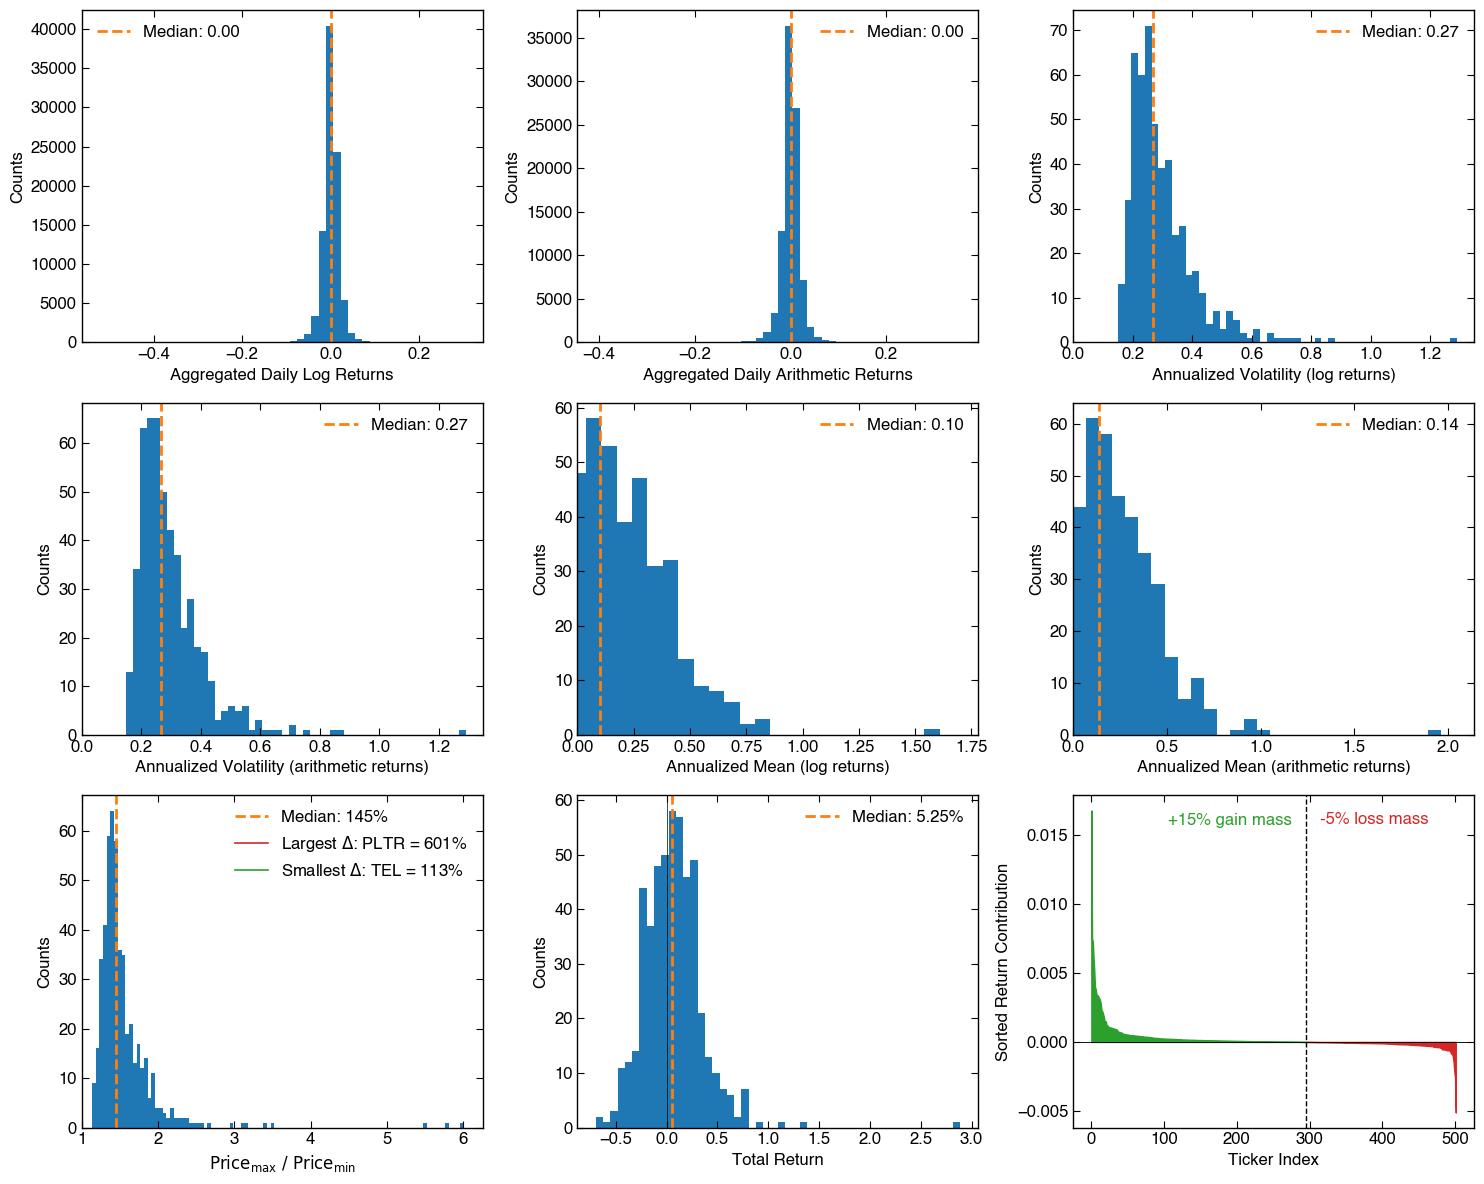

In [222]:
fig, axes = plt.subplots(3, 3, figsize=(15,12))
axes = axes.flatten()

iax = 0
all_logret = logret.values.flatten()
axes[iax].hist(all_logret, bins=50)
axes[iax].axvline(np.median(all_logret), color='tab:orange', linewidth=2, linestyle='--', label=f'Median: {np.median(all_logret):.2f}')
axes[iax].set_xlabel("Aggregated Daily Log Returns")
axes[iax].set_ylabel("Counts")
axes[iax].legend()

iax = 1
all_arithret = arithret.values.flatten()
axes[iax].hist(all_arithret, bins=50)
axes[iax].axvline(np.median(all_arithret), color='tab:orange', linewidth=2, linestyle='--', label=f'Median: {np.median(all_arithret):.2f}')
axes[iax].set_xlabel("Aggregated Daily Arithmetic Returns")
axes[iax].set_ylabel("Counts")
axes[iax].legend()

iax = 2
axes[iax].hist(ann_vol_log, bins=50)
axes[iax].axvline(np.median(ann_vol_log), color='tab:orange', linewidth=2, linestyle='--', label=f'Median: {np.median(ann_vol_log):.2f}')
axes[iax].set_xlabel("Annualized Volatility (log returns)")
axes[iax].set_ylabel("Counts")
axes[iax].set_xlim(0)
axes[iax].legend()

iax = 3
axes[iax].hist(ann_vol_arith, bins=50)
axes[iax].axvline(np.median(ann_vol_arith), color='tab:orange', linewidth=2, linestyle='--', label=f'Median: {np.median(ann_vol_arith):.2f}')
axes[iax].set_xlabel("Annualized Volatility (arithmetic returns)")
axes[iax].set_ylabel("Counts")
axes[iax].set_xlim(0)
axes[iax].legend()

idx = 4
axes[idx].hist(ann_mean_log, bins=50)
axes[idx].axvline(np.median(ann_mean_log), color='tab:orange', linewidth=2, linestyle='--', label=f'Median: {np.median(ann_mean_log):.2f}')
axes[idx].set_xlabel("Annualized Mean (log returns)")
axes[idx].set_ylabel("Counts")
axes[idx].set_xlim(0)
axes[idx].legend()

iax = 5
axes[iax].hist(ann_mean_arith, bins=50)
axes[iax].axvline(np.median(ann_mean_arith), color='tab:orange', linewidth=2, linestyle='--', label=f'Median: {np.median(ann_mean_arith):.2f}')
axes[iax].set_xlabel("Annualized Mean (arithmetic returns)")
axes[iax].set_ylabel("Counts")
axes[iax].set_xlim(0)
axes[iax].legend()

# Maximum price range distribution
iax = 6
max_delta_pct = open_data.max(axis=0) / open_data.min(axis=0)
median_delta = max_delta_pct.median()
highest_delta = max_delta_pct.idxmax()
smallest_delta = max_delta_pct.idxmin()
axes[iax].hist(max_delta_pct, bins=100)
axes[iax].axvline(median_delta, color='tab:orange', linewidth=2, linestyle='--', label=f'Median: {median_delta:.0%}')
axes[iax].plot([], [], label=f"Largest $\\Delta$: {highest_delta} = {max_delta_pct[highest_delta]:.0%}", color='tab:red')
axes[iax].plot([], [], label=f"Smallest $\\Delta$: {smallest_delta} = {max_delta_pct[smallest_delta]:.0%}", color='tab:green')
axes[iax].legend()
axes[iax].set_xlim(1)
axes[iax].set_ylabel("Counts")
axes[iax].set_xlabel(r"$\text{Price}_{\text{max}}~/~\text{Price}_{\text{min}}$")

# Total Return Distribution
iax = 7
median_ret = tot_ret.median()
axes[iax].hist(tot_ret, bins=50)
axes[iax].set_xlabel('Total Return')
axes[iax].set_ylabel('Counts')
axes[iax].axvline(0, color='black', linewidth=0.5)
axes[iax].axvline(median_ret, color='tab:orange', linewidth=2, linestyle='--', label=f'Median: {median_ret:.2%}')
axes[iax].legend()

# Sorted return contribution
iax = 8
gain_to_loss_index = contrib_sorted[contrib_sorted['contribution'] > 0].index[-1]
gain_mass = contrib_sorted.loc[:gain_to_loss_index, 'contribution'].sum()
loss_mass = contrib_sorted.loc[gain_to_loss_index:, 'contribution'].sum()
axes[iax].fill_between(range(0, gain_to_loss_index+1), contrib_sorted.loc[:gain_to_loss_index, 'contribution'].values, color='tab:green')
axes[iax].fill_between(range(gain_to_loss_index, len(contrib_sorted)), contrib_sorted.loc[gain_to_loss_index:, 'contribution'].values, color='tab:red')
axes[iax].axvline(gain_to_loss_index, color='black', linewidth=1, linestyle='--')
axes[iax].axhline(0, color='black', linewidth=0.5)
axes[iax].text(gain_to_loss_index-20, axes[iax].get_ylim()[1]*0.9, f'+{gain_mass:.0%} gain mass', color='tab:green', ha='right', va='center')
axes[iax].text(gain_to_loss_index+20, axes[iax].get_ylim()[1]*0.9, f'{loss_mass:.0%} loss mass', color='tab:red', ha='left', va='center')
axes[iax].axhline(0, color='black', linewidth=0.5)
axes[iax].set_xlabel('Ticker Index')
axes[iax].set_ylabel('Sorted Return Contribution')

plt.tight_layout()

In [223]:
# Print paragraph of summary
md = Markdown(f"""
The S&P 500 index has a median annualized volatility of {np.median(ann_vol_arith):.2%} and a median price range (Price_max / Price_min) of {median_delta:.0%}. The S&P 500 index has a median total return of {median_ret:.2%}. An attempt to compute the contribution of each ticker to the index return is currently misleading since the latest market cap data is used (baking in past returns again). With the current procedure, the gain mass is {gain_mass:.0%} and the loss mass is {loss_mass:.0%}.""")
console.print(md)

The S&P 500 index has a median annualized volatility of 26.72% and a median price range (Price_max / Price_min) of 
145%. The S&P 500 index has a median total return of 5.25%. An attempt to compute the contribution of each ticker  
to the index return is currently misleading since the latest market cap data is used (baking in past returns       
again). With the current procedure, the gain mass is 15% and the loss mass is -5%.

# Discounted Cash Flow

How should a company be valued?
- A company’s value to shareholders is the present value of its free cash flows.
- The DCF model has two components:
  1. **Explicit Forecast**: Project future FCF by applying historical growth to the most recent FCF.
  2. **Terminal Value**: Beyond a chosen horizon, assume a constant perpetual growth rate to capture all remaining cash flows.
- Both projected FCF and terminal value are discounted to today using a discount rate (e.g., cost of equity).


**Side note**
- There are alternatives to determine the "Fair Value" of a company
- Discounted Cash Flow (DCF): Fair value = Present value of all future expected cash flows.
- Multiples: Fair value = Comparable company multiple * company metric (e.g., EBITDA, revenue, cash flow).
- Market implied: The price implied by arbitrage-free pricing models (e.g. for derivatives, forward contracts).


## References
- Professor Aswath Damodaran’s Data (NYU Stern):
  - WACC by Industry: https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/wacc.htm
  - Long-Term Growth Rates by Industry: https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/growth.htm

## Hyperparameters
- $r$ = discount rate (e.g., WACC or cost of equity)
  - required return that investors demand for bearing the firm’s risk
  - Typical range: 6 % – 12 % for U.S. large-cap firms
  - Empirical distribution: median ~8 % – 10 %; technology firms often 10 % – 14 %, utilities 5 % – 8 %
- $g_{\infty}$ = terminal (perpetual) growth rate
  - Typical range: 1 % – 3 % for mature U.S. companies
  - Empirical distribution: defensive sectors 1 % – 2 %, steady growers 2 % – 3 %, rarely > 4 % in perpetuity
- $T$ = explicit forecast horizon (in years)
  - Typical range: 5 – 10 years
  - Empirical usage: 5 years for mature businesses, 7 – 10 years for high-growth or transition firms

## Equations
- Calculate CAGR from the previous 5 years of annual FCF
  - $g = \text{CAGR} \;=\; \Bigl(\frac{\text{AnnualFCF}_{n}}{\text{AnnualFCF}_{\,n-5}}\Bigr)^{\frac{1}{5}} \;-\; 1$
- If fewer than 6 years of data, use fallback formula
  - $g = \text{CAGR}_{\text{fallback}} \;=\; \frac{1}{m-1} \sum_{k=1}^{m-1}\Bigl(\frac{\text{AnnualFCF}_{\,k}}{\text{AnnualFCF}_{\,k-1}} - 1\Bigr), \quad (m < 6)$
- Calculate projected FCF for $t = 1, 2, \dots, T$
  - $\widehat{\text{FCF}}_{\,n+t} \;=\; \text{AnnualFCF}_{\,n} \times (1 + g)^{\,t}$
- Calculate terminal value at the end of year $n + T$
  - $\text{TerminalValue}_{\,n+T} \;=\; \frac{\widehat{\text{FCF}}_{\,n+T} \times (1 + g_{\infty})}{\,r - g_{\infty}\,}$
- Present value of explicit forecast (years $n+1$ through $n+T$)
  - $\text{PV}_{\text{explicit}} \;=\; \sum_{t=1}^{T} \frac{\widehat{\text{FCF}}_{\,n + t}}{(1 + r)^{\,t}}$
- Present value of terminal value
  - $\text{PV}_{\text{terminal}} \;=\; \frac{\text{TerminalValue}_{\,n+T}}{(1 + r)^{\,T}}$
- Total DCF valuation
  - $\text{DCF Value} \;=\; \sum_{t=1}^{T} \frac{\widehat{\text{FCF}}_{\,n + t}}{(1 + r)^{\,t}} \;+\; \frac{\text{TerminalValue}_{\,n+T}}{(1 + r)^{\,T}}$


## WACC

Under the **Capital Asset Pricing Model (CAPM)**, the **cost of equity** is given by:

$ r_e = r_f + \beta \times (r_m - r_f) $

The **cost of debt** is typically estimated based on the firm’s borrowing rate, and the **after-tax** cost of debt is:

$ r_d = r_{\text{pre-tax}} \times (1 - T) $

where:
- $ r_f $ is the risk-free rate,
- $ \beta $ is the equity beta,
- $ r_m $ is the expected return on the market,
- $ T $ is the corporate tax rate.


**Intuitively**, it asks the question: "How much extra return should I expect to receive for bearing the risk of this stock compared to the risk-free rate?"
- investors should atleast demand the risk-free rate, $r_f$
- investors should demand a premium for holding riskier (compared to $r_f$) assets like stock indexes, this is **Market Risk Premium**
- investors should demand more or less depending on the volatility of the stock compared to the market, $\beta$
- investors understand debt has interest which must be paid but also that the interest is tax deductible, $T$

The **Weighted Average Cost of Capital (WACC)** is then given by:

$ \text{WACC} = w_e \times r_e + w_d \times r_{\text{d}} $

where:
- $ w_e $ and $ w_d $ are the market value weights of equity and debt, respectively,
- $ r_e $ is the cost of equity,
- $ r_d $ is the after-tax cost of debt.


Text(0.5, 1.0, 'Effective Tax Rate')

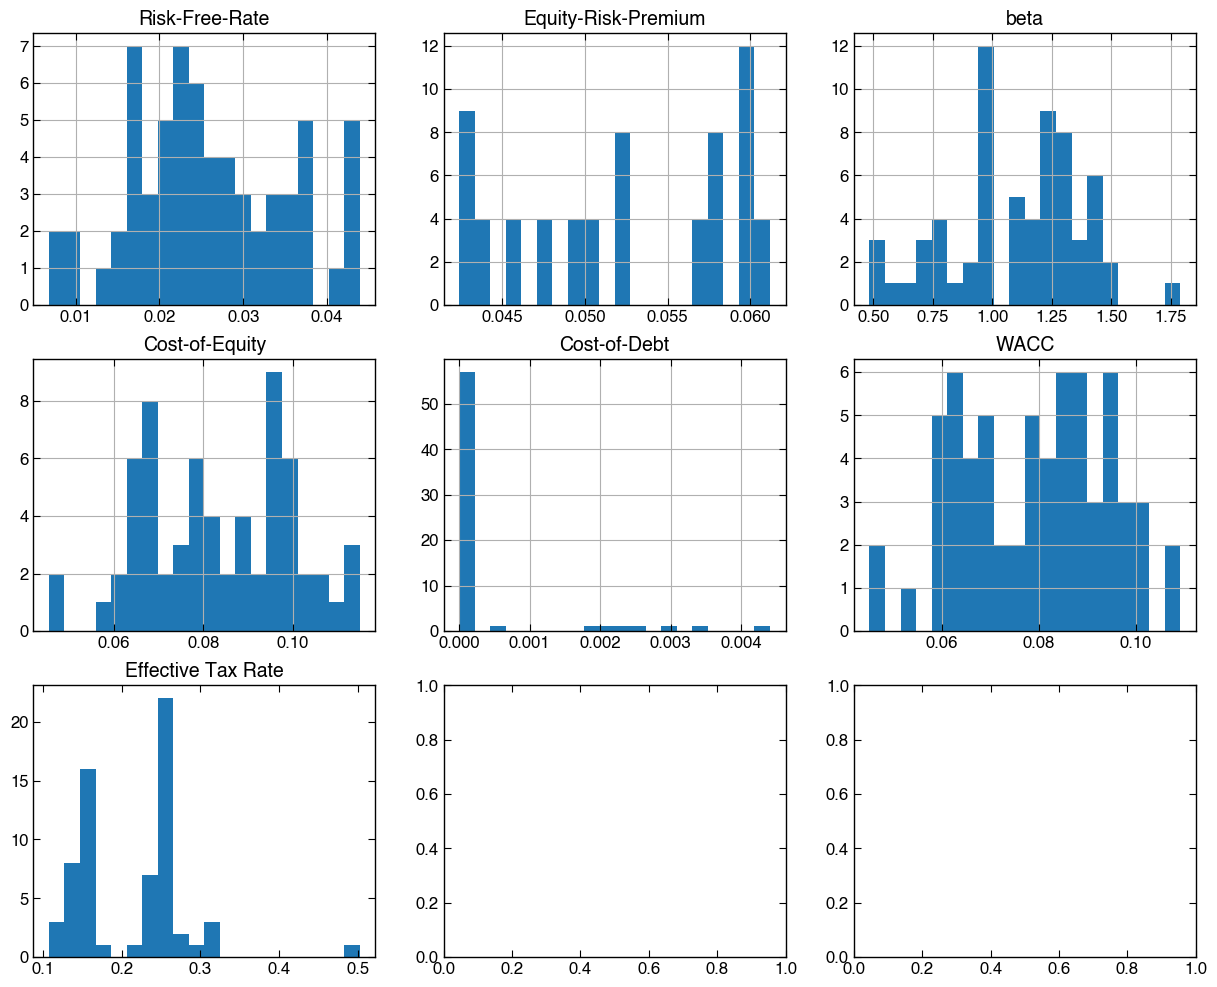

In [294]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# Plot histograms for each column
columns = ['Risk-Free-Rate', 'Equity-Risk-Premium', 'beta', 'Cost-of-Equity', 'Cost-of-Debt', 'WACC']

for i, column in enumerate(columns):
    ax = axes[i//3, i%3]
    macrotrends['AAPL'][column].hist(bins=20, ax=ax)
    ax.set_title(column)
    
axes[2, 0].hist(macrotrends['AAPL']['Income-Taxes'] / macrotrends['AAPL']['Pre-Tax-Income'], bins=20)
axes[2, 0].set_title('Effective Tax Rate')

In [252]:
# Define prior distributions tailored for solar/tech companies.
# Reasoning:
# - Discount rate: High beta suggests high systematic risk, solar industry risks
# - Growth rate: Solar/tech FCF historically very volatile, long-term sustainable growth variable
# - Terminal growth: Should be ≤ long-term GDP growth, conservative for mature companies
# - Time horizon: Uniform between 5-10 years

# Discount rate: Range 7% to 16%, centered around 11%
r_mean, r_std, r_low, r_high = 0.11, 0.02, 0.07, 0.16
a_r, b_r = (r_low - r_mean)/r_std, (r_high - r_mean)/r_std

# Terminal growth: Range 1% to 4%, centered around 2.5%
gT_mean, gT_std, gT_low, gT_high = 0.025, 0.008, 0.01, 0.04
a_gT, b_gT = (gT_low - gT_mean)/gT_std, (gT_high - gT_mean)/gT_std

prior_distributions = {
    'discount_rate': truncnorm(a=a_r, b=b_r, loc=r_mean, scale=r_std),
    'growth_rate': norm(loc=0.05, scale=0.04),  # Mean 5%, std 4%
    'terminal_growth': truncnorm(a=a_gT, b=b_gT, loc=gT_mean, scale=gT_std),
    'time_horizon': uniform(loc=5, scale=5)  # Uniform[5, 10]
}

# Define correlation matrix for solar/tech company parameters.
# Reasoning:
# - High correlation between discount_rate and growth_rate (0.8)
# - Moderate correlations for time_horizon with rates (0.5-0.6)
# - Lower correlation for terminal_growth (0.2-0.4)

correlation_matrix = np.array([
    [1.0,  0.8,  0.2,  0.5],  # discount_rate
    [0.8,  1.0,  0.3,  0.6],  # growth_rate
    [0.2,  0.3,  1.0,  0.4],  # terminal_growth
    [0.5,  0.6,  0.4,  1.0]   # time_horizon
])

In [253]:
%load_ext autoreload
%autoreload 2
from fundamentals.utility.dcf import StandardDCFModel

dcf_model = StandardDCFModel()
dcf_model.configure_priors(prior_distributions, correlation_matrix)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [255]:
dcf_model.simulate(macrotrends['AAPL'], n_samples=100000)

────────────────────────── Monte Carlo DCF Simulation ──────────────────────────
  Sampling parameters...     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 0:00:00% 0:00:00 -:--:--
0.1163470886072241ions... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% 0:00:00 -:--:--
  Sampling parameters...     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 0:00:00
  Sampling parameters...     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 0:00:00
WACC: 0.07906635129100535 +- 0.015260966094303257━━━━━━━━━━━━━━━━━━   0% 0:00:00 -:--:--
  Sampling parameters...     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 0:00:00
0.0766156863692253ions... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% 0:00:00 -:--:--
  Sampling parameters...     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 0:00:00
WACC: 0.07906635129100535 +- 0.015260966094303257━━━━━━━━━━━━━━━━━━   0% 0:00:00 -:--:--
  Sampling parameters...     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 0:00:00
0.11008833166274182ons... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% 0:00:00 -:--:--
  Sa

KeyboardInterrupt: 

Creating DCF terms diagnostic plot...
✓ DCF terms diagnostic plot generated successfully


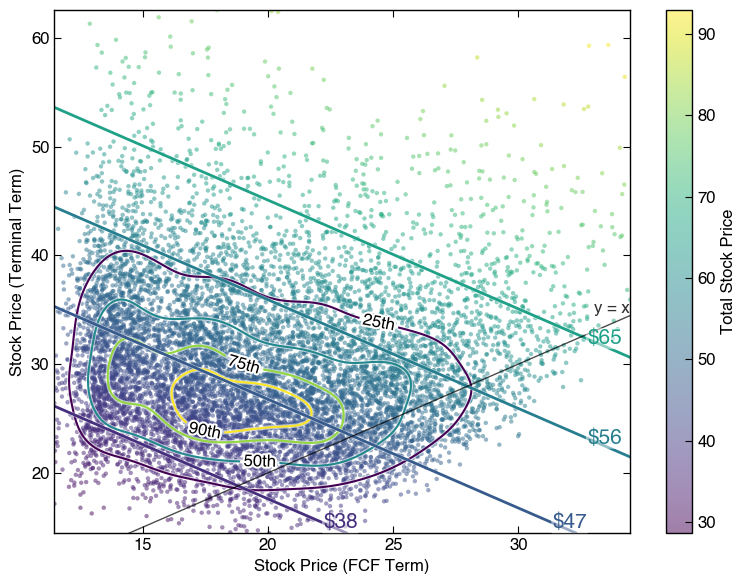

In [249]:
_ = dcf_model.plot_terms_diagnostics()

Creating diagnostic corner plots...
✓ Corner plots generated successfully


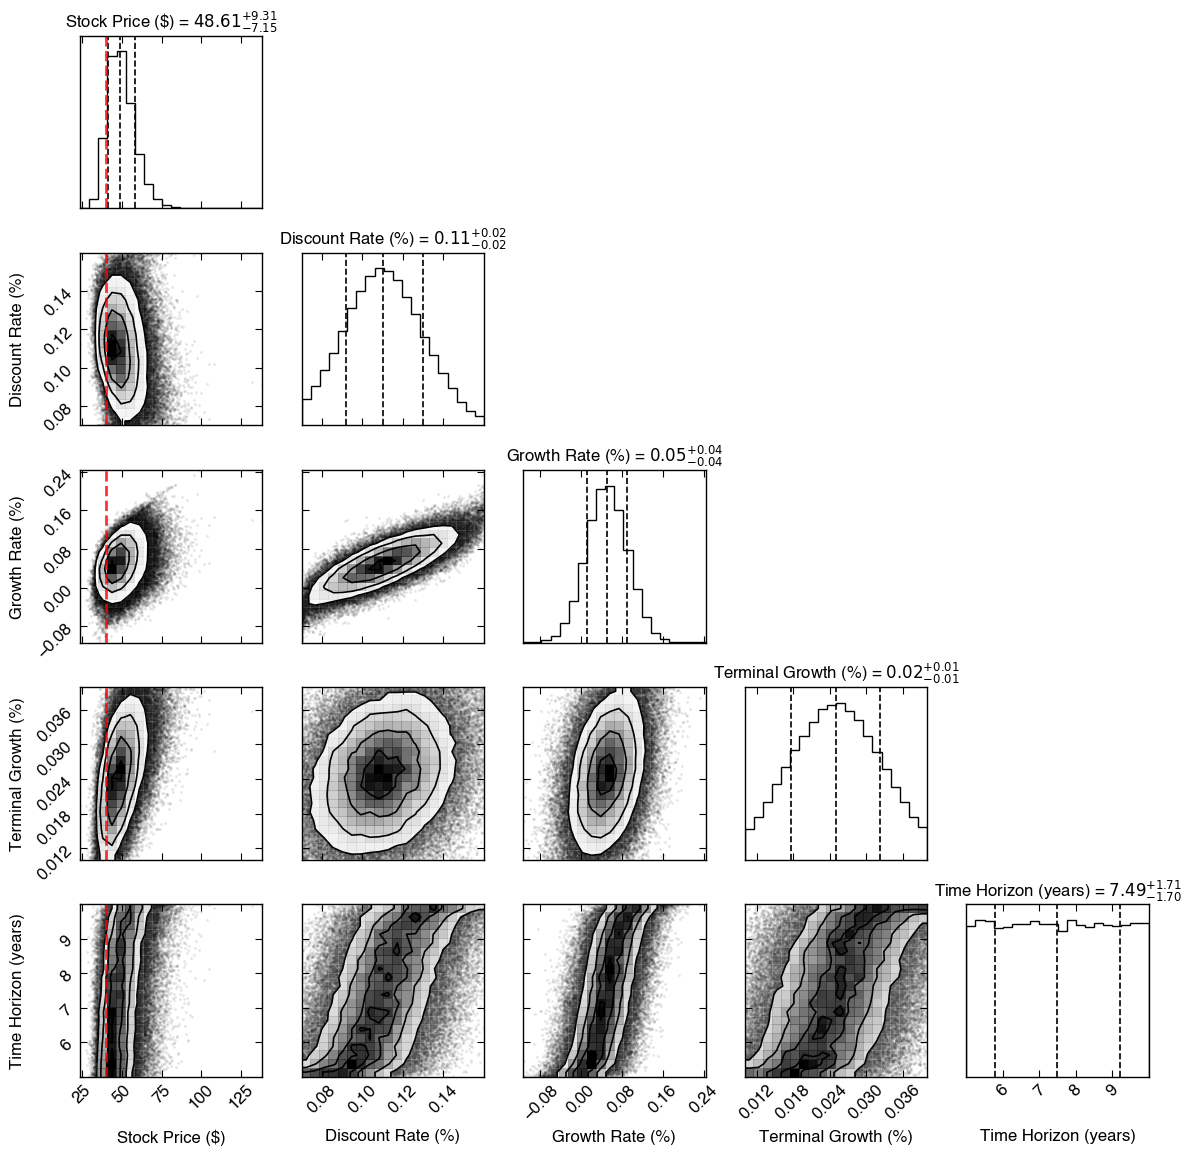

In [250]:
_ = dcf_model.plot_corner_diagnostics(current_stock_price=40)